In [1]:

#
# Aniosotropic tissue (fibers at 45 degrees) with the Aliev-Panfilov model.
# Anisotropy is set by specifying a fiber array (CardiacTissue class) and
# diffusion coefficients D_al, D_ac (diffusion along and across fibers).
# Alqways use AsymmetricStencil for weights computations in case of anisotropic tissue.
#


import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import pandas as pd

import finitewave as fw

# number of nodes on the side
n = 400

alphas = np.radians(np.arange(0, 91, 15))
print(len(alphas))
density = np.arange(0, 0.31, 0.05)
# loop over different anisotropy coefficients
d = 0
out = []
images = []
for alpha in alphas:
    tissue = fw.CardiacTissue2D([n, n])
    # create a mesh of cardiomyocytes (elems = 1):
    tissue.mesh = np.ones([n, n])
    tissue.mesh[np.random.random([n, n]) < d] = 2
    tissue.add_boundaries()
    # add fibers orientation vectors
    tissue.fibers = np.zeros([n, n, 2])
    tissue.fibers[:, :, 0] = np.cos(alpha)
    tissue.fibers[:, :, 1] = np.sin(alpha)
    # add numeric method stencil for weights computations
    tissue.stencil = fw.AsymmetricStencil2D()
    tissue.D_al = 1
    tissue.D_ac = tissue.D_al/9

    # create model object:
    aliev_panfilov = fw.AlievPanfilov2D()
    # set up numerical parameters:
    aliev_panfilov.dt = 0.01
    aliev_panfilov.dr = 0.25
    aliev_panfilov.t_max = 30
    # set up stimulation parameters:
    stim_sequence = fw.StimSequence()
    stim_sequence.add_stim(fw.StimVoltageCoord2D(0, 1, n//2 - 3, n//2 + 3,
                                                n//2 - 3, n//2 + 3))
    # add the tissue and the stim parameters to the model object:
    aliev_panfilov.cardiac_tissue = tissue
    aliev_panfilov.stim_sequence = stim_sequence

    aliev_panfilov.run()

    labeled = ski.measure.label(aliev_panfilov.u > 0.5)
    props = ski.measure.regionprops_table(labeled, properties=(
        'orientation', 'major_axis_length', 'minor_axis_length'))
    props['orientation'] = np.degrees(props['orientation'])
    props['axis_ratio'] = props['major_axis_length'] / props['minor_axis_length']
    props['alpha'] = np.degrees(alpha)
    props['density_calc'] = (np.sum(tissue.mesh[-1:1, -1:1] == 2) 
                                / ((n - 2) * (n - 2)))
    images.append(aliev_panfilov.u.copy())

    out.append(pd.DataFrame(props))

out = pd.concat(out)

7


Running AlievPanfilov2D: 100%|██████████| 3000/3000 [00:04<00:00, 680.02it/s]


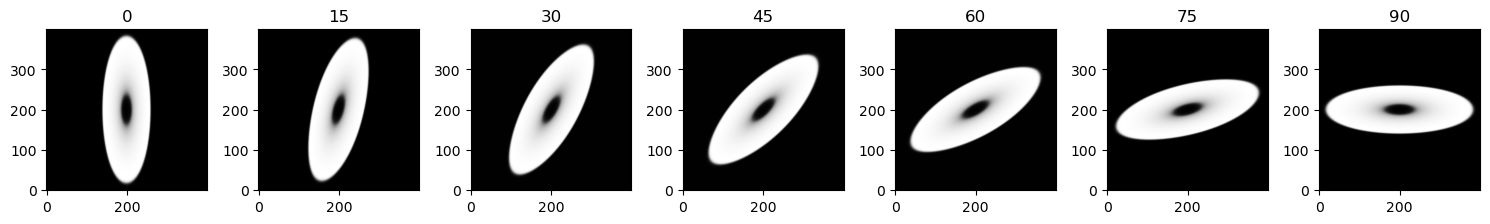

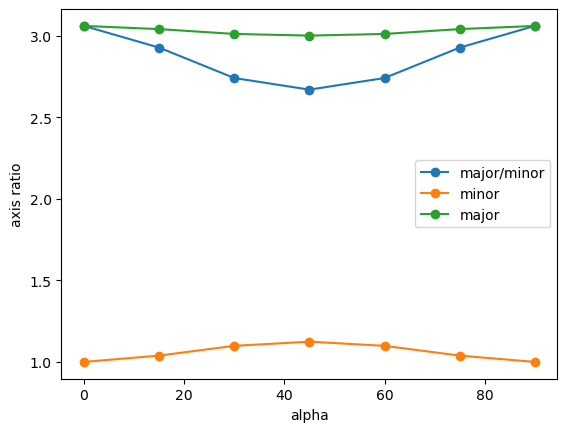

In [2]:
fig, axs = plt.subplots(ncols=7, figsize=(15, 5))

for i, ax in enumerate(axs):
    ax.imshow(images[i], cmap='gray', origin='lower')
    ax.set_title(f'{np.degrees(alphas[i]):.0f}')

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(out['alpha'], out['axis_ratio'], 'o-', label='major/minor')
plt.plot(out['alpha'], out['minor_axis_length'] / out['minor_axis_length'].min(), 'o-', label='minor')
plt.plot(out['alpha'], out['major_axis_length'] / out['minor_axis_length'].min(), 'o-', label='major')
plt.xlabel('alpha')
plt.ylabel('axis ratio')
plt.legend()
plt.show()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import pandas as pd

import finitewave as fw

# number of nodes on the side
n = 400

alphas = np.radians(np.arange(0, 91, 15))
# loop over different anisotropy coefficients
d = 0.1
out_10 = []
images_10 = []
for alpha in alphas:
    tissue = fw.CardiacTissue2D([n, n])
    # create a mesh of cardiomyocytes (elems = 1):
    tissue.mesh = np.ones([n, n])
    tissue.mesh[np.random.random([n, n]) < d] = 2
    tissue.add_boundaries()
    # add fibers orientation vectors
    tissue.fibers = np.zeros([n, n, 2])
    tissue.fibers[:, :, 0] = np.cos(alpha)
    tissue.fibers[:, :, 1] = np.sin(alpha)
    # add numeric method stencil for weights computations
    tissue.stencil = fw.AsymmetricStencil2D()
    tissue.D_al = 1
    tissue.D_ac = tissue.D_al/9

    # create model object:
    aliev_panfilov = fw.AlievPanfilov2D()
    # set up numerical parameters:
    aliev_panfilov.dt = 0.01
    aliev_panfilov.dr = 0.25
    aliev_panfilov.t_max = 30
    # set up stimulation parameters:
    stim_sequence = fw.StimSequence()
    stim_sequence.add_stim(fw.StimVoltageCoord2D(0, 1, n//2 - 3, n//2 + 3,
                                                n//2 - 3, n//2 + 3))
    # add the tissue and the stim parameters to the model object:
    aliev_panfilov.cardiac_tissue = tissue
    aliev_panfilov.stim_sequence = stim_sequence

    aliev_panfilov.run()

    labeled = ski.measure.label(aliev_panfilov.u > 0.5)
    props = ski.measure.regionprops_table(labeled, properties=(
        'orientation', 'major_axis_length', 'minor_axis_length'))
    props['orientation'] = np.degrees(props['orientation'])
    props['axis_ratio'] = props['major_axis_length'] / props['minor_axis_length']
    props['alpha'] = np.degrees(alpha)
    props['density_calc'] = (np.sum(tissue.mesh[-1:1, -1:1] == 2) 
                                / ((n - 2) * (n - 2)))
    images_10.append(aliev_panfilov.u.copy())

    out_10.append(pd.DataFrame(props))

out_10 = pd.concat(out_10)

Running AlievPanfilov2D: 100%|██████████| 3000/3000 [00:06<00:00, 494.37it/s]
/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_4601/2130542833.py:51: RuntimeWarning: invalid value encountered in divide
  props['axis_ratio'] = props['major_axis_length'] / props['minor_axis_length']
Running AlievPanfilov2D: 100%|██████████| 3000/3000 [00:06<00:00, 489.56it/s]


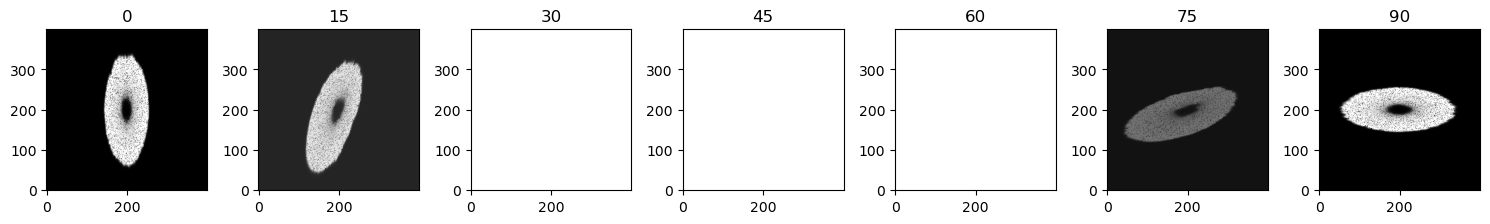

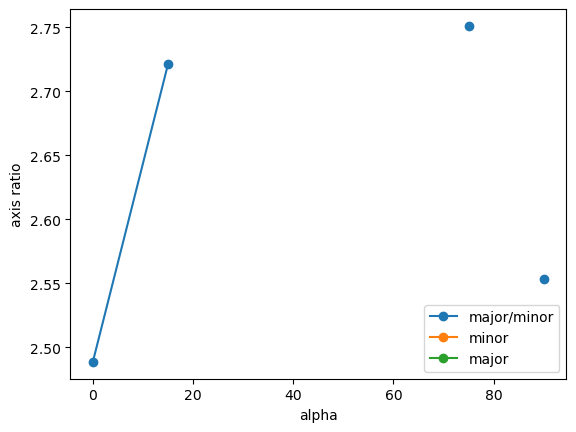

In [4]:
fig, axs = plt.subplots(ncols=7, figsize=(15, 5))

for i, ax in enumerate(axs):
    ax.imshow(images_10[i], cmap='gray', origin='lower')
    ax.set_title(f'{np.degrees(alphas[i]):.0f}')

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(out_10['alpha'], out_10['axis_ratio'], 'o-', label='major/minor')
plt.plot(out_10['alpha'], out_10['minor_axis_length'] / out_10['minor_axis_length'].min(), 'o-', label='minor')
plt.plot(out_10['alpha'], out_10['major_axis_length'] / out_10['minor_axis_length'].min(), 'o-', label='major')
plt.xlabel('alpha')
plt.ylabel('axis ratio')
plt.legend()
plt.show()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import pandas as pd

import finitewave as fw

%matplotlib qt

# number of nodes on the side
n = 400

alpha = np.radians(45)
mesh = np.load('mesh.npy')
# # loop over different anisotropy coefficients
d = 0.1
tissue = fw.CardiacTissue2D([n, n])
# create a mesh of cardiomyocytes (elems = 1):
# tissue.mesh = np.ones([n, n])
# tissue.mesh[np.random.random([n, n]) < d] = 2
tissue.mesh = mesh.astype(int)
tissue.add_boundaries()
# add fibers orientation vectors
tissue.fibers = np.zeros([n, n, 2])
tissue.fibers[:, :, 0] = np.cos(alpha)
tissue.fibers[:, :, 1] = np.sin(alpha)
# add numeric method stencil for weights computations
tissue.stencil = fw.AsymmetricStencil2D()
tissue.D_al = 1
tissue.D_ac = tissue.D_al/9

# create model object:
aliev_panfilov = fw.AlievPanfilov2D()
# set up numerical parameters:
aliev_panfilov.dt = 0.01
aliev_panfilov.dr = 0.25
aliev_panfilov.t_max = 6.
# set up stimulation parameters:
stim_sequence = fw.StimSequence()
stim_sequence.add_stim(fw.StimVoltageCoord2D(0, 1, n//2 - 3, n//2 + 3,
                                            n//2 - 3, n//2 + 3))
# add the tissue and the stim parameters to the model object:
aliev_panfilov.cardiac_tissue = tissue
aliev_panfilov.stim_sequence = stim_sequence

aliev_panfilov.run()

u = aliev_panfilov.u.copy()
u[tissue.mesh != 1] = np.nan

# x = 180
# y = 220
x = 50
y = 350
plt.figure()
plt.imshow(u[x:y, x:y], cmap='viridis', origin='lower')
plt.show()

Running AlievPanfilov2D: 100%|██████████| 600/600 [00:01<00:00, 484.21it/s]


In [38]:
np.save('mesh.npy', tissue.mesh)